# How to train your Hidden Markov Model

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate()
; 

  Activating project at `c:\Users\adami\Documents\Git repositories\RXInfer_example_GraphPPLv4\RxInfer.jl\examples`


In this example, we'll be tracking a Roomba as it moves throughout a 3-bedroom apartment consisting of a bathroom, a master bedroom, and a living room. It's important to keep track of your AI's, so we want to make sure we can keep tabs on it whenever we leave the apartment. 




First, in order to track the Roomba's movements using `RxInfer`, we need to come up with a model. Since we have a discrete set of rooms in the apartment, we can use a categorical distribution to represent the Roomba's position. There are three  rooms in the apartment, meaning we need three states in our categorical distribution. At time $t$, let's call the estimate of the Roomba's position $s_t$.

However, we also know that some rooms are more accessible than others, meaning the Roomba is more likely to move between these rooms - for example, it's rare to have a door directly between the bathroom and the master bedroom. We can encode this information using a transition matrix, which we will call $A$.

Our Roomba is equipped with a small camera that tracks the surface it is moving over. We will use this camera to obtain our observations since we know that there is a carpet in the living room, tiles in the bathroom, and hardwood floors in the master bedroom. However, this method is not foolproof, and sometimes the Roomba will make mistakes and mistake the hardwood floor for tiles or the carpet for hardwood. Don't be too hard on the little guy, it's just a Roomba after all.

At time $t$, we will call our observations $x_t$ and encode the mapping from the Roomba's position to the observations in a matrix we call $B$. $B$ also encodes the likelihood that the Roomba will make a mistake and get the wrong observation. This leaves us with the following model specification:


$$\begin{aligned}
    s_t & \sim \mathcal{C}at(A s_{t-1}),\\
    x_t & \sim \mathcal{C}at(B s_t).\\
\end{aligned}$$

This type of discrete state space model is known as a *Hidden Markov Model* or HMM for short. Our goal is to learn the matrices $A$ and $B$ so we can use them to track the whereabouts of our little cleaning agent.

In [2]:
using RxInfer, Random, BenchmarkTools, Distributions, LinearAlgebra, Plots

In order to generate data to mimic the observations of the Roomba, we need to specify two things: the actual transition probabilities between the states (i.e., how likely is the Roomba to move from one room to another), and the observation distribution (i.e., what type of texture will the Roomba encounter in each room). We can then use these specifications to generate observations from our hidden Markov model (HMM).

To generate our observation data, we'll follow these steps:
1. Assume an initial state for the Roomba. For example, we can start the Roomba in the bedroom.
2. Determine where the Roomba went next by drawing from a Categorical distribution with the transition probabilities between the different rooms.
3. Determine the observation encountered in this room by drawing from a Categorical distribution with the corresponding observation probabilities.
4. Repeat steps 2-3 for as many samples as we want.

The following code implements this process and generates our observation data:


In [3]:
"""
    rand_vec(rng, distribution::Categorical)

This function returns a one-hot encoding of a random sample from a categorical distribution. The sample is drawn with the `rng` random number generator.
"""
function rand_vec(rng, distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    drawn_category = rand(rng, distribution)
    s[drawn_category] = 1.0
    return s
end

function generate_data(n_samples; seed = 42)
    
    rng = MersenneTwister(seed)
    
    # Transition probabilities 
    state_transition_matrix = [0.9 0.0 0.1;
                                                        0.0 0.9 0.1; 
                                                        0.05 0.05 0.9] 
    # Observation noise
    observation_distribution_matrix = [0.9 0.05 0.05;
                                                                         0.05 0.9 0.05;
                                                                         0.05 0.05 0.9] 
    # Initial state
    s_initial = [1.0, 0.0, 0.0] 
    
    states = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    observations = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_initial
    
    for t = 1:n_samples
        s_probvec = state_transition_matrix * s_prev
        states[t] = rand_vec(rng, Categorical(s_probvec ./ sum(s_probvec)))
        obs_probvec = observation_distribution_matrix * states[t]
        observations[t] = rand_vec(rng, Categorical(obs_probvec ./ sum(obs_probvec)))
        s_prev = states[t]
    end
    
    return observations, states
end

generate_data (generic function with 1 method)

We will generate 100 data points to simulate 100 ticks of the Roomba moving through the apartment. `x_data` will contain the Roomba's measurements of the floor it's currently on, and `s_data` will contain information on the room the Roomba was actually in.

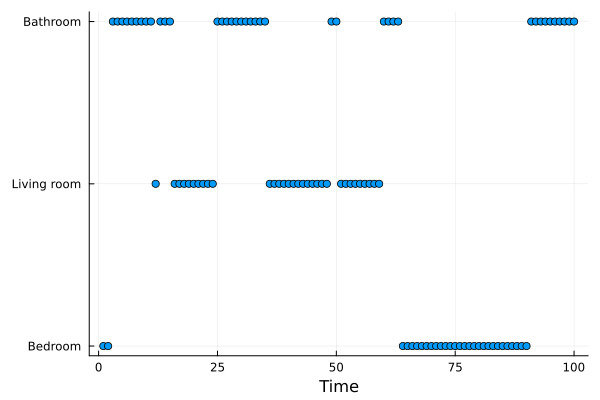

In [4]:
# Test data
N = 100
x_data, s_data = generate_data(N);

scatter(argmax.(s_data), leg=false, xlabel="Time",yticks= ([1,2,3],["Bedroom","Living room","Bathroom"]))

Now it is time to build our model. As mentioned earlier, we will use Categorical distributions for the states and observations. To learn the $A$ and $B$ matrices we can use `MatrixDirichlet` priors. For the $A$-matrix, since we have no apriori idea how the roomba is actually going to move we will assume that it moves randomly. We can represent this by filling our `MatrixDirichlet` prior on $A$ with ones. Remember that this will get updated once we start learning, so it's fine if our initial guess is not quite accurate.
As for the observations, we have good reason to trust our Roomba's measurements. To represent this, we will add large values to the diagonal of our prior on $B$. However, we also acknowledge that the Roomba is not infallible, so we will add some noise on the off-diagonal entries.

Since we will use Variational Inference, we also have to specify inference constraints. We will use a structured variational approximation to the true posterior distribution, where we decouple the variational posterior over the states (`q(s_0, s)`) from the posteriors over the transition matrices (`q(A)` and `q(B)`). This dependency decoupling in the approximate posterior distribution ensures that inference is tractable. Let's build the model!

In [5]:
# Model specification
@model function hidden_markov_model(x)
    
    A ~ MatrixDirichlet(ones(3,3))
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 
                                            1.0 10.0 1.0; 
                                            1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s_prev = s_0
    
    for t in eachindex(x)
        s[t] ~ Transition(s_prev, A) 
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
end

# Constraints specification
@constraints function hidden_markov_model_constraints()
    q(s_0, s, A, B) = q(s_0, s)q(A)q(B)
end

hidden_markov_model_constraints (generic function with 1 method)

Now it's time to perform inference and find out where the Roomba went in our absence. Did it remember to clean the bathroom?

We'll be using Variational Inference to perform inference, which means we need to set some initial marginals as a starting point. RxInfer makes this easy with the `vague` function, which provides an uninformative guess. If you have better ideas, you can try a different initial guess and see what happens.

Since we're only interested in the final result - the best guess about the Roomba's position - we'll only keep the last results. Let's start the inference process!

In [6]:
imarginals = (
    A = vague(MatrixDirichlet, 3, 3), 
    B = vague(MatrixDirichlet, 3, 3), 
    s = vague(Categorical, 3)
)

ireturnvars = (
    A = KeepLast(),
    B = KeepLast(),
    s = KeepLast()
)

result = infer(
    model         = hidden_markov_model(), 
    data          = (x = x_data,),
    constraints   = hidden_markov_model_constraints(),
    initmarginals = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 20, 
    free_energy   = true
);

That was fast! Let's take a look at our results. If we're successful, we should have a good idea about the actual layout of the apartment (a good posterior marginal over $A$) and about the uncertainty in the roombas observations (A good posterior over $B$). Let's see if it worked

In [7]:
println("Posterior Marginal for A:")
mean(result.posteriors[:A])

Posterior Marginal for A:


3×3 Matrix{Float64}:
 0.871955   0.0290008  0.0572283
 0.0349989  0.817591   0.135675
 0.0930457  0.153408   0.807097

In [8]:
println("Posterior Marginal for B:")
mean(result.posteriors[:B])

Posterior Marginal for B:


3×3 Matrix{Float64}:
 0.949636   0.0974741  0.0518997
 0.0244903  0.833632   0.0277884
 0.0258734  0.0688939  0.920312

Finally, we can check if we were successful in keeping tabs on our Roomba's whereabouts. We can also check if our model has converged by looking at the Free Energy. 


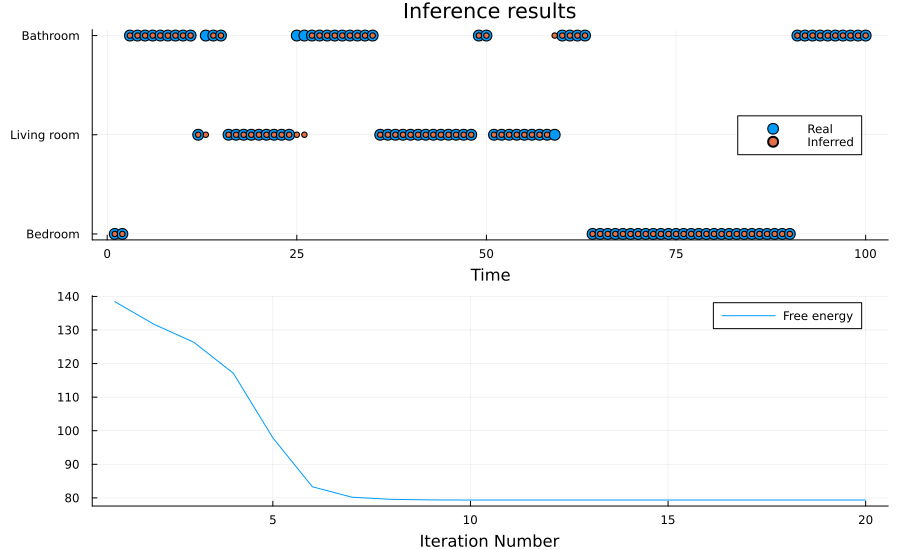

In [9]:
p1 = scatter(argmax.(s_data), 
                        title="Inference results", 
                        label = "Real", 
                        ms = 6, 
                        legend=:right,
                        xlabel="Time" ,
                        yticks= ([1,2,3],["Bedroom","Living room","Bathroom"]),
                        size=(900,550)
                        )

p1 = scatter!(p1, argmax.(ReactiveMP.probvec.(result.posteriors[:s])),
                        label = "Inferred",
                        ms = 3
                        )

p2 = plot(result.free_energy, 
                    label="Free energy",
                    xlabel="Iteration Number"
                    )

plot(p1, p2, layout = @layout([ a; b ]))

Neat! Now you know how to track a Roomba if you ever need to. You also learned how to fit a Hidden Markov Model using `RxInfer` in the process.